In [ ]:
# Instalasi
!pip install transformers datasets scikit-learn

In [ ]:
import os
import re
import json
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from huggingface_hub import HfApi
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    return text.strip()


In [ ]:
df = pd.read_excel("/content/dataset.xlsx")
df['clean_text'] = df['full_text'].apply(clean_text)
df['label'] = df['label'].apply(lambda x: 1 if 'bot' in str(x).lower() else 0)

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

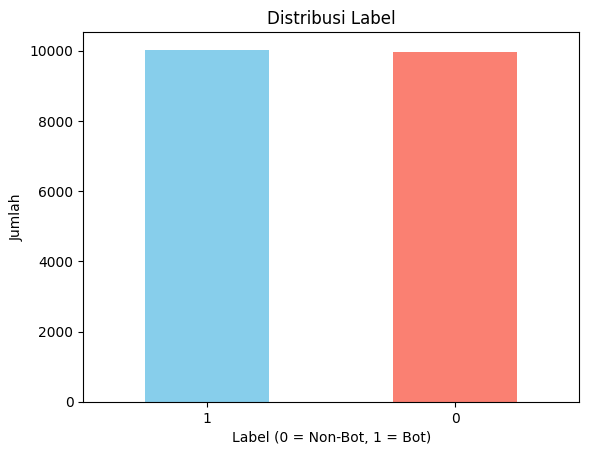

In [ ]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribusi Label')
plt.xlabel('Label (0 = Non-Bot, 1 = Bot)')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
MAX_LEN = 128

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = TweetDataset(train_df["clean_text"].tolist(), train_df["label"].tolist())
val_dataset = TweetDataset(val_df["clean_text"].tolist(), val_df["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class IndoBERT_LSTM(nn.Module):
    def __init__(self):
        super(IndoBERT_LSTM, self).__init__()
        self.bert = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
        self.lstm = nn.LSTM(self.bert.config.hidden_size, 128, batch_first=True)
        self.classifier = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        _, (hidden, _) = self.lstm(bert_output)
        logits = self.classifier(hidden[-1])
        return self.sigmoid(logits)


In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
from huggingface_hub import notebook_login, Repository

In [ ]:
from huggingface_hub import create_repo, upload_file
import torch
import torch.nn as nn
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

repo_id = "yazidsupriadi/indo_lstm_bot"
local_dir = "indo_lstm_bot"
os.makedirs(local_dir, exist_ok=True)

create_repo(repo_id, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IndoBERT_LSTM().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

log_file = os.path.join(local_dir, "training_log.md")
readme_file = os.path.join(local_dir, "README.md")

with open(log_file, "w") as f:
    f.write("# Training Log: IndoBERT + LSTM for Bot Detection\n\n")

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    train_preds, train_targets = [], []
    train_probs = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        probs = outputs.detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        train_probs.extend(probs)
        train_preds.extend(preds)
        train_targets.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_targets, train_preds)
    train_prec = precision_score(train_targets, train_preds, zero_division=0)
    train_rec = recall_score(train_targets, train_preds, zero_division=0)
    train_f1 = f1_score(train_targets, train_preds, zero_division=0)

    model.eval()
    val_preds, val_targets, val_probs = [], [], []
    with torch.no_grad():
        for val_batch in val_loader:
            input_ids = val_batch["input_ids"].to(device)
            attention_mask = val_batch["attention_mask"].to(device)
            labels = val_batch["labels"].to(device)

            outputs = model(input_ids, attention_mask).squeeze()
            probs = outputs.cpu().numpy()
            preds = (probs > 0.5).astype(int)

            val_probs.extend(probs)
            val_preds.extend(preds)
            val_targets.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    val_prec = precision_score(val_targets, val_preds, zero_division=0)
    val_rec = recall_score(val_targets, val_preds, zero_division=0)
    val_f1 = f1_score(val_targets, val_preds, zero_division=0)
    val_roc_auc = roc_auc_score(val_targets, val_probs)

    print(
        f"📊 Epoch {epoch+1} Results:\n"
        f"Train Loss       : {total_loss / len(train_loader):.4f}\n"
        f"Train Accuracy   : {train_acc:.4f} | Precision: {train_prec:.4f} | Recall: {train_rec:.4f} | F1-score: {train_f1:.4f}\n"
        f"Val Accuracy     : {val_acc:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1-score: {val_f1:.4f} | ROC AUC: {val_roc_auc:.4f}\n"
    )

    with open(log_file, "a") as f:
        f.write(f"## Epoch {epoch+1}\n")
        f.write(f"- Train Loss: {total_loss / len(train_loader):.4f}\n")
        f.write(f"- Train Accuracy: {train_acc:.4f}\n")
        f.write(f"- Train Precision: {train_prec:.4f}\n")
        f.write(f"- Train Recall: {train_rec:.4f}\n")
        f.write(f"- Train F1-score: {train_f1:.4f}\n")
        f.write(f"- Validation Accuracy: {val_acc:.4f}\n")
        f.write(f"- Validation Precision: {val_prec:.4f}\n")
        f.write(f"- Validation Recall: {val_rec:.4f}\n")
        f.write(f"- Validation F1-score: {val_f1:.4f}\n")
        f.write(f"- Validation ROC AUC: {val_roc_auc:.4f}\n\n")

    # Simpan model setelah tiap epoch
    model_save_path = os.path.join(local_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), model_save_path)

    # Update README.md
    with open(log_file, "r") as src, open(readme_file, "w") as dst:
        dst.write(src.read())

    # Upload file log, README, dan model
    upload_file(path_or_fileobj=log_file, path_in_repo="training_log.md", repo_id=repo_id, repo_type="model")
    upload_file(path_or_fileobj=readme_file, path_in_repo="README.md", repo_id=repo_id, repo_type="model")
    upload_file(path_or_fileobj=model_save_path, path_in_repo=f"model_epoch_{epoch+1}.pth", repo_id=repo_id, repo_type="model")

print("✅ Training selesai dan model card berhasil diperbarui.")


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Epoch 1 - Training: 100%|██████████| 1000/1000 [01:55<00:00,  8.63it/s]


📊 Epoch 1 Results:
Train Loss       : 0.5315
Train Accuracy   : 0.7618 | Precision: 0.7418 | Recall: 0.8052 | F1-score: 0.7722
Val Accuracy     : 0.7995 | Precision: 0.7883 | Recall: 0.8205 | F1-score: 0.8041 | ROC AUC: 0.8834



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_1.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 2 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


📊 Epoch 2 Results:
Train Loss       : 0.4204
Train Accuracy   : 0.8094 | Precision: 0.8054 | Recall: 0.8174 | F1-score: 0.8114
Val Accuracy     : 0.8147 | Precision: 0.8102 | Recall: 0.8235 | F1-score: 0.8168 | ROC AUC: 0.9018



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_2.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 3 - Training: 100%|██████████| 1000/1000 [01:51<00:00,  8.96it/s]


📊 Epoch 3 Results:
Train Loss       : 0.3931
Train Accuracy   : 0.8223 | Precision: 0.8246 | Recall: 0.8200 | F1-score: 0.8223
Val Accuracy     : 0.8235 | Precision: 0.8134 | Recall: 0.8410 | F1-score: 0.8270 | ROC AUC: 0.9094



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_3.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 4 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.02it/s]


📊 Epoch 4 Results:
Train Loss       : 0.3742
Train Accuracy   : 0.8326 | Precision: 0.8377 | Recall: 0.8264 | F1-score: 0.8320
Val Accuracy     : 0.8293 | Precision: 0.8173 | Recall: 0.8495 | F1-score: 0.8330 | ROC AUC: 0.9155



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_4.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 5 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


📊 Epoch 5 Results:
Train Loss       : 0.3615
Train Accuracy   : 0.8399 | Precision: 0.8491 | Recall: 0.8278 | F1-score: 0.8383
Val Accuracy     : 0.8205 | Precision: 0.7872 | Recall: 0.8799 | F1-score: 0.8310 | ROC AUC: 0.9178



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_5.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 6 - Training: 100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]


📊 Epoch 6 Results:
Train Loss       : 0.3534
Train Accuracy   : 0.8409 | Precision: 0.8512 | Recall: 0.8275 | F1-score: 0.8392
Val Accuracy     : 0.8365 | Precision: 0.8340 | Recall: 0.8415 | F1-score: 0.8377 | ROC AUC: 0.9211



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_6.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 7 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s]


📊 Epoch 7 Results:
Train Loss       : 0.3429
Train Accuracy   : 0.8478 | Precision: 0.8606 | Recall: 0.8311 | F1-score: 0.8456
Val Accuracy     : 0.8420 | Precision: 0.8338 | Recall: 0.8554 | F1-score: 0.8445 | ROC AUC: 0.9241



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_7.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 8 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s]


📊 Epoch 8 Results:
Train Loss       : 0.3374
Train Accuracy   : 0.8506 | Precision: 0.8627 | Recall: 0.8350 | F1-score: 0.8486
Val Accuracy     : 0.8390 | Precision: 0.8280 | Recall: 0.8569 | F1-score: 0.8422 | ROC AUC: 0.9247



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_8.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 9 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.07it/s]


📊 Epoch 9 Results:
Train Loss       : 0.3274
Train Accuracy   : 0.8550 | Precision: 0.8687 | Recall: 0.8375 | F1-score: 0.8528
Val Accuracy     : 0.8448 | Precision: 0.8341 | Recall: 0.8619 | F1-score: 0.8478 | ROC AUC: 0.9270



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_9.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

Epoch 10 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s]


📊 Epoch 10 Results:
Train Loss       : 0.3240
Train Accuracy   : 0.8572 | Precision: 0.8696 | Recall: 0.8416 | F1-score: 0.8554
Val Accuracy     : 0.8427 | Precision: 0.8354 | Recall: 0.8549 | F1-score: 0.8450 | ROC AUC: 0.9275



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


model_epoch_10.pth:   0%|          | 0.00/500M [00:00<?, ?B/s]

✅ Training selesai dan model card berhasil diperbarui.


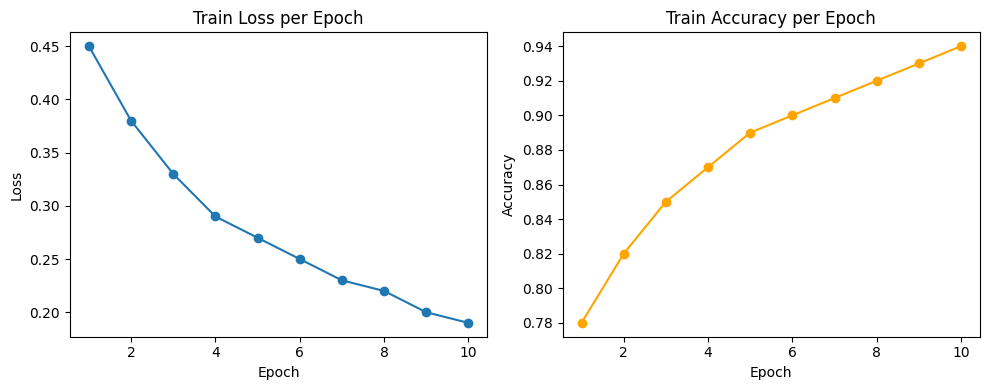

In [ ]:
train_losses = [0.45, 0.38, 0.33, 0.29, 0.27, 0.25, 0.23, 0.22, 0.20, 0.19]
train_accuracies = [0.78, 0.82, 0.85, 0.87, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94]
EPOCHS = len(train_losses)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o')
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accuracies, marker='o', color='orange')
plt.title("Train Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


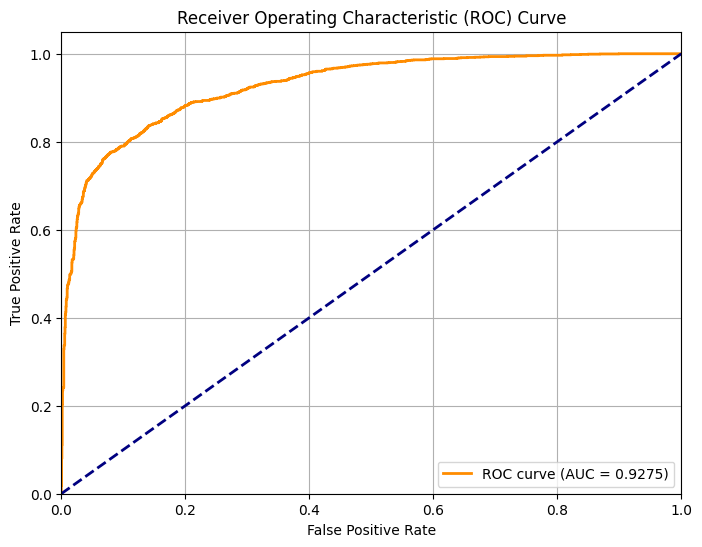

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(val_targets, val_probs):
    fpr, tpr, _ = roc_curve(val_targets, val_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Misal di akhir epoch, setelah validasi selesai dan kamu sudah punya val_targets dan val_probs
plot_roc_curve(val_targets, val_probs)


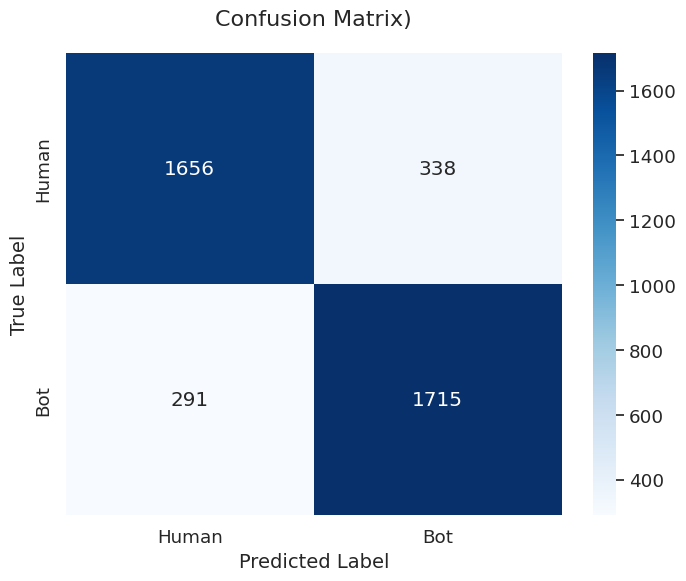

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Data Confusion Matrix (Updated: Human = Negatif, Bot = Positif)
confusion_matrix = np.array([
    [1656,  338],  # True Human, False Bot
    [291, 1715]   # False Human, True Bot
])
colors = ["white", "#b3d9ff", "#66b3ff", "#0080ff", "#0059b3"]  # Gradien biru
cmap_custom = LinearSegmentedColormap.from_list("blue_white", colors)


# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ukuran font
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "Bot"], yticklabels=["Human", "Bot"])


# Label dan Judul
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix)', fontsize=16, pad=20)

plt.show()

In [ ]:
from sklearn.metrics import classification_report

def print_classification_report(true_labels, pred_labels, target_names=['Negatif', 'Positif']):
    report = classification_report(true_labels, pred_labels, target_names=target_names, zero_division=0)
    print("=== Classification Report ===")
    print(report)

# Contoh pemakaian setelah evaluasi model:
print_classification_report(val_targets, val_preds)


=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.85      0.83      0.84      1994
     Positif       0.84      0.85      0.85      2006

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



📊 Epoch 1 Results:
Train Loss       : 0.5315
Train Accuracy   : 0.7618 | Precision: 0.7418 | Recall: 0.8052 | F1-score: 0.7722
Val Accuracy     : 0.7995 | Precision: 0.7883 | Recall: 0.8205 | F1-score: 0.8041 | ROC AUC: 0.8834

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_1.pth: 100%
 500M/500M [00:14<00:00, 52.8MB/s]
Epoch 2 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]
📊 Epoch 2 Results:
Train Loss       : 0.4204
Train Accuracy   : 0.8094 | Precision: 0.8054 | Recall: 0.8174 | F1-score: 0.8114
Val Accuracy     : 0.8147 | Precision: 0.8102 | Recall: 0.8235 | F1-score: 0.8168 | ROC AUC: 0.9018

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_2.pth: 100%
 500M/500M [00:11<00:00, 40.8MB/s]
Epoch 3 - Training: 100%|██████████| 1000/1000 [01:51<00:00,  8.96it/s]
📊 Epoch 3 Results:
Train Loss       : 0.3931
Train Accuracy   : 0.8223 | Precision: 0.8246 | Recall: 0.8200 | F1-score: 0.8223
Val Accuracy     : 0.8235 | Precision: 0.8134 | Recall: 0.8410 | F1-score: 0.8270 | ROC AUC: 0.9094

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_3.pth: 100%
 500M/500M [00:11<00:00, 51.8MB/s]
Epoch 4 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.02it/s]
📊 Epoch 4 Results:
Train Loss       : 0.3742
Train Accuracy   : 0.8326 | Precision: 0.8377 | Recall: 0.8264 | F1-score: 0.8320
Val Accuracy     : 0.8293 | Precision: 0.8173 | Recall: 0.8495 | F1-score: 0.8330 | ROC AUC: 0.9155

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_4.pth: 100%
 500M/500M [00:11<00:00, 50.3MB/s]
Epoch 5 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]
📊 Epoch 5 Results:
Train Loss       : 0.3615
Train Accuracy   : 0.8399 | Precision: 0.8491 | Recall: 0.8278 | F1-score: 0.8383
Val Accuracy     : 0.8205 | Precision: 0.7872 | Recall: 0.8799 | F1-score: 0.8310 | ROC AUC: 0.9178

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_5.pth: 100%
 500M/500M [00:12<00:00, 25.4MB/s]
Epoch 6 - Training: 100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]
📊 Epoch 6 Results:
Train Loss       : 0.3534
Train Accuracy   : 0.8409 | Precision: 0.8512 | Recall: 0.8275 | F1-score: 0.8392
Val Accuracy     : 0.8365 | Precision: 0.8340 | Recall: 0.8415 | F1-score: 0.8377 | ROC AUC: 0.9211

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_6.pth: 100%
 500M/500M [00:13<00:00, 49.5MB/s]
Epoch 7 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s]
📊 Epoch 7 Results:
Train Loss       : 0.3429
Train Accuracy   : 0.8478 | Precision: 0.8606 | Recall: 0.8311 | F1-score: 0.8456
Val Accuracy     : 0.8420 | Precision: 0.8338 | Recall: 0.8554 | F1-score: 0.8445 | ROC AUC: 0.9241

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_7.pth: 100%
 500M/500M [00:12<00:00, 52.8MB/s]
Epoch 8 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s]
📊 Epoch 8 Results:
Train Loss       : 0.3374
Train Accuracy   : 0.8506 | Precision: 0.8627 | Recall: 0.8350 | F1-score: 0.8486
Val Accuracy     : 0.8390 | Precision: 0.8280 | Recall: 0.8569 | F1-score: 0.8422 | ROC AUC: 0.9247

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_8.pth: 100%
 500M/500M [00:12<00:00, 51.0MB/s]
Epoch 9 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.07it/s]
📊 Epoch 9 Results:
Train Loss       : 0.3274
Train Accuracy   : 0.8550 | Precision: 0.8687 | Recall: 0.8375 | F1-score: 0.8528
Val Accuracy     : 0.8448 | Precision: 0.8341 | Recall: 0.8619 | F1-score: 0.8478 | ROC AUC: 0.9270

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_9.pth: 100%
 500M/500M [00:11<00:00, 31.3MB/s]
Epoch 10 - Training: 100%|██████████| 1000/1000 [01:50<00:00,  9.04it/s]
📊 Epoch 10 Results:
Train Loss       : 0.3240
Train Accuracy   : 0.8572 | Precision: 0.8696 | Recall: 0.8416 | F1-score: 0.8554
Val Accuracy     : 0.8427 | Precision: 0.8354 | Recall: 0.8549 | F1-score: 0.8450 | ROC AUC: 0.9275

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
model_epoch_10.pth: 100%
 500M/500M [00:12<00:00, 40.7MB/s]
✅ Training selesai dan model card berhasil diperbarui.

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for val_batch in val_loader:
            input_ids = val_batch["input_ids"].to(device)
            attention_mask = val_batch["attention_mask"].to(device)
            labels = val_batch["labels"].to(device)

            outputs = model(input_ids, attention_mask).squeeze()
            val_preds.extend((outputs > 0.5).int().cpu().numpy())
            val_targets.extend(labels.int().cpu().numpy())

    train_loss = total_loss / len(train_loader)
    acc = accuracy_score(val_targets, val_preds)

    train_losses.append(train_loss)
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Accuracy: {acc:.4f}")

    # Logging ke Markdown
    with open(log_file, "a") as f:
        f.write(f"## Epoch {epoch+1}\n")
        f.write(f"- Train Loss: {train_loss:.4f}\n")
        f.write(f"- Validation Accuracy: {acc:.4f}\n\n")

    # Simpan model
    model_path = os.path.join(local_dir, f"model_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), model_path)

    # Push ke HF repo
    repo.push_to_hub(commit_message=f"Epoch {epoch+1} - Model & Log")

# Visualisasi Loss & Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig(os.path.join(local_dir, "training_plot.png"))
repo.push_to_hub(commit_message="Add training plot")

print("Model disimpan dan visualisasi selesai.")


Epoch 1: 100%|██████████| 717/717 [01:27<00:00,  8.23it/s]


Epoch 1 - Train Loss: 0.4251 - Val Accuracy: 0.8149


To https://huggingface.co/yazidsupriadi/indo_lstm_bot
   5f4cd23..5af46e6  main -> main

   5f4cd23..5af46e6  main -> main

Epoch 2: 100%|██████████| 717/717 [01:26<00:00,  8.28it/s]


Epoch 2 - Train Loss: 0.4049 - Val Accuracy: 0.8222


To https://huggingface.co/yazidsupriadi/indo_lstm_bot
   5af46e6..dfe0732  main -> main

   5af46e6..dfe0732  main -> main

Epoch 3: 100%|██████████| 717/717 [01:26<00:00,  8.27it/s]


Epoch 3 - Train Loss: 0.3924 - Val Accuracy: 0.8229


To https://huggingface.co/yazidsupriadi/indo_lstm_bot
   dfe0732..aa04855  main -> main

   dfe0732..aa04855  main -> main

Epoch 4:  36%|███▋      | 261/717 [00:31<00:55,  8.29it/s]

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import upload_file
import os

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
val_preds, val_targets = [], []

# === Kumpulkan Prediksi dan Target ===
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask).squeeze()
        predictions = (outputs > 0.5).int().cpu().numpy()
        targets = labels.int().cpu().numpy()

        val_preds.extend(predictions)
        val_targets.extend(targets)

# === Laporan Klasifikasi ===
report = classification_report(val_targets, val_preds, target_names=["Human", "Bot"], digits=4)
conf_matrix = confusion_matrix(val_targets, val_preds)

print(report)

# === Simpan Laporan ke evaluation.md ===
local_dir = "./model_output"
os.makedirs(local_dir, exist_ok=True)
evaluation_path = os.path.join(local_dir, "evaluation.md")

with open(evaluation_path, "w") as f:
    f.write("# 📊 Evaluation Result - IndoBERT + LSTM\n\n")
    f.write("## Classification Report\n")
    f.write("```\n")
    f.write(report)
    f.write("```\n")

# === Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Bot", "Bot"], yticklabels=["Not Bot", "Bot"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - IndoBERT + LSTM")

cm_img_path = os.path.join(local_dir, "confusion_matrix.png")
plt.savefig(cm_img_path)
plt.close()

# === Upload ke Hugging Face Hub ===
repo_id = "yazidsupriadi/indo_lstm_bot"

upload_file(path_or_fileobj=evaluation_path, path_in_repo="evaluation.md", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj=cm_img_path, path_in_repo="confusion_matrix.png", repo_id=repo_id, repo_type="model")

# === Tambahkan Gambar ke README ===
readme_path = os.path.join(local_dir, "README.md")
readme_hub = "README.md"

# Download dulu isi README lama kalau mau edit manual, atau update langsung:
with open(readme_path, "a") as f:
    f.write("\n## 📷 Confusion Matrix\n")
    f.write("![Confusion Matrix](./confusion_matrix.png)\n")

upload_file(path_or_fileobj=readme_path, path_in_repo=readme_hub, repo_id=repo_id, repo_type="model")

print("✅ Evaluasi selesai dan diunggah ke model card.")


              precision    recall  f1-score   support

       Human     0.8505    0.8305    0.8404      1994
         Bot     0.8354    0.8549    0.8450      2006

    accuracy                         0.8427      4000
   macro avg     0.8430    0.8427    0.8427      4000
weighted avg     0.8429    0.8427    0.8427      4000



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9664: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


✅ Evaluasi selesai dan diunggah ke model card.


In [ ]:
def predict(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask).squeeze(-1)
        prediction = (output > 0.5).int().cpu().item()  # 1 = Bot, 0 = Human

    return "Bot" if prediction == 1 else "Human"

# Contoh prediksi tweet baru
text = "test"
result = predict(text)
print(f"Prediksi: {result}")


Prediksi: Human
